### Building Autoencoders

In this workshop, we will look at three different types of autoencoders - a simple autoencoder used for data compression, a sparse autoencoder used for data compression and sparse feature learning, and a variational autoencoder, a generative model used to generate new samples similar to our dataset. Let's get started!


####  Vanilla Autoencoder
![](https://raw.githubusercontent.com/uclaacmai/advanced-track-fall18/master/autoencoder-workshop/assets/autoencoder.jpg)

We'll build this autoencoder with just a single fully-connected layer for the encoder network, and a single fully-connected layer for the decoder network. As an exercise, we'll add additional layers into our network to see how that affects the reconstruction quality.

We will also need to have a notion of loss to quantify the quality of our reconstructed images. We'll use a pixel by pixel binary cross entropy for this.

In [116]:
from keras.layers import Input, Dense
from keras.models import Model
# prepare input data
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],-1))
x_test = x_test.reshape((x_test.shape[0],-1))

In [2]:
# We will create a Keras model using the Model API, we will define our inputs and outputs and construct a model based on that.
# https://keras.io/models/model/

# encoded representation
dim = 32

# this is our input placeholder
image_input = Input(shape=(784,))
# encoded representation
encoded = Dense(dim, activation='relu')(image_input)
# decoded (reconstruction) representation
decoded = Dense(784, activation='sigmoid')(encoded)

# Create 3 models: the autoencoder that goes from image -> encoding -> decoding
# the encoder, and the decoder separately
# this model maps an input to its reconstruction
autoencoder = Model(input=image_input, output=decoded)

# decoder model, takes in an encoding
encoded_image = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_image, output=decoder_layer(encoded_image))

# encoder model
encoder = Model(input=image_input, output=encoded)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [3]:
# compile our model to use binary cross entropy
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 4s - loss: 0.3630 - val_loss: 0.2720

In [27]:
import matplotlib.pyplot as plt
def plot(x_test, decoded_images):
    decoded_imgs = decoded_images
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
def plot_encoding(encoded_imgs):
    n = 10
    plt.figure(figsize=(20, 8))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(encoded_imgs[i].reshape(4,-1).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### Visualizing
Let's plot our data!

In [28]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(encoded_imgs.mean())

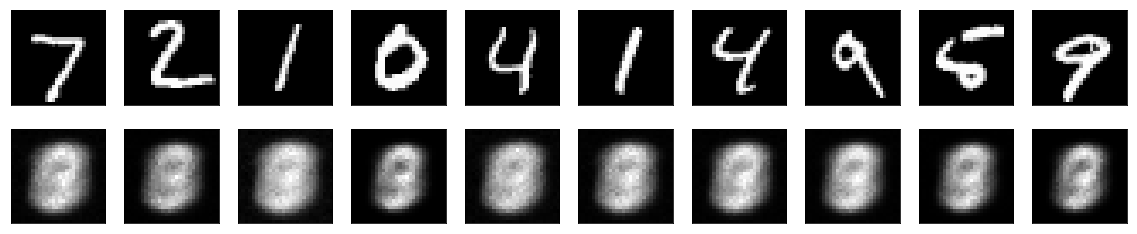

In [29]:
plot(x_test,decoded_imgs)

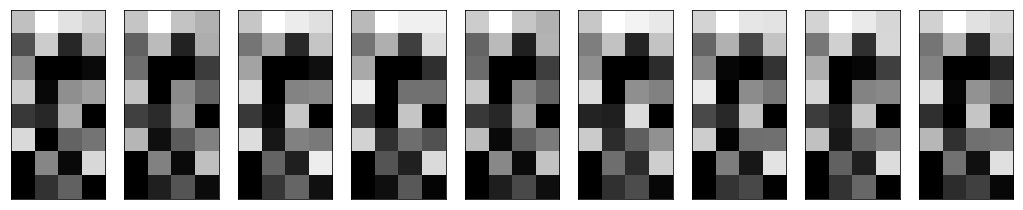

In [30]:
plot_encoding(encoded_imgs)

Let's see if we can improve this autoencoder by adding some more layers.

In [31]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
# TODO - add 2 more layers with 64 and 32 neurons respectively
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
#TODO - add 2 more layers with 128 and input_shape  neurons respectively
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [33]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 6s - loss: 0.2634 - val_loss: 0.2591

In [60]:
#TODO - call plot() and plot_encoding() to visualize the results
from keras.models import Sequential
encoder = Sequential([autoencoder.layers[0], autoencoder.layers[1], autoencoder.layers[2]])

decoder = Sequential(autoencoder.layers[3:])

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)


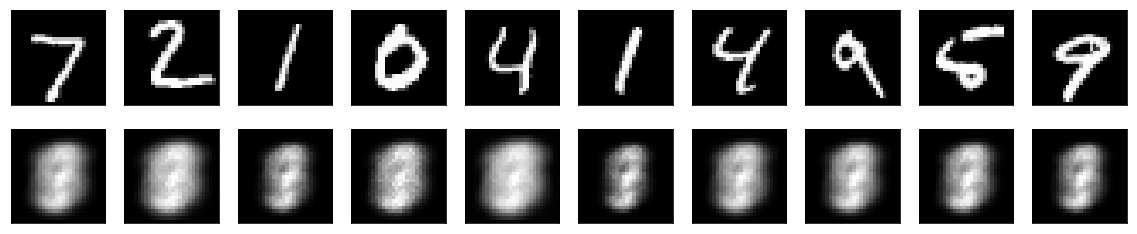

In [61]:
plot(x_test, decoded_imgs)

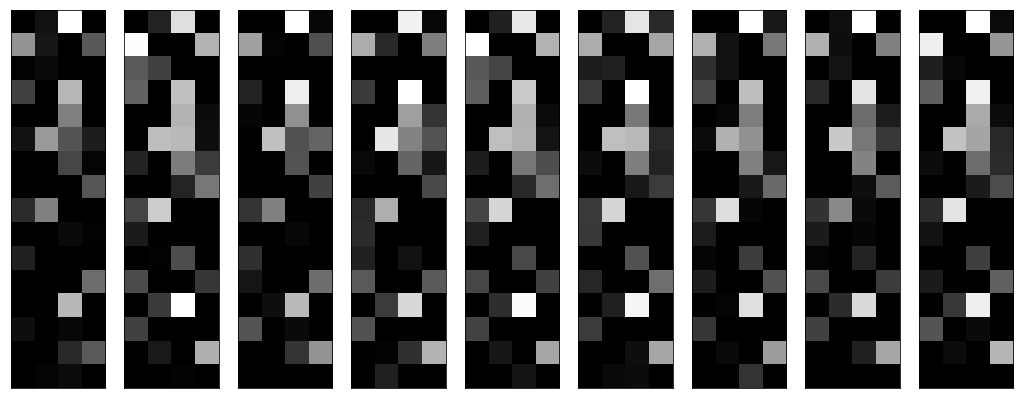

In [62]:
plot_encoding(encoded_imgs)

### Sparse Autoencoder

All we neeed to do for a sparse autoencoder is place a $L1$ norm regularizer on our encoding network, to encourage it to learn a sparse representation of our encoding.

In [63]:
# encoded representation
from keras import regularizers
encoded = Dense(dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(image_input)
# decoded (reconstruction) representation
decoded = Dense(784, activation='sigmoid')(encoded)

# Create 3 models: the autoencoder that goes from image -> encoding -> decoding
# the encoder, and the decoder separately
# this model maps an input to its reconstruction
autoencoder = Model(input=image_input, output=decoded)

# decoder model, takes in an encoding
encoded_image = Input(shape=(dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_image, output=decoder_layer(encoded_image))

# encoder model
encoder = Model(input=image_input, output=encoded)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [64]:
# compile our model to use binary cross entropy
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 5s - loss: 0.6830 - val_loss: 0.6606

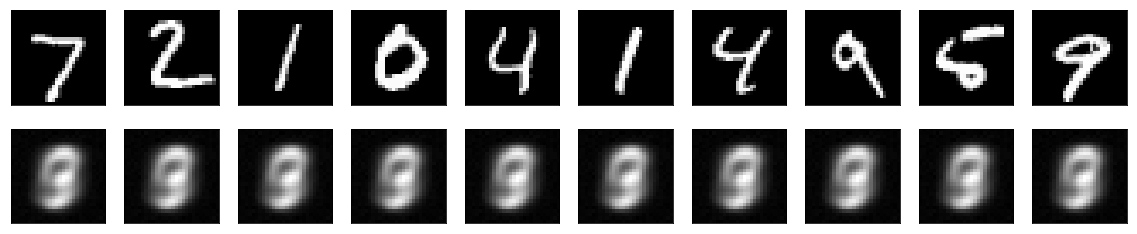

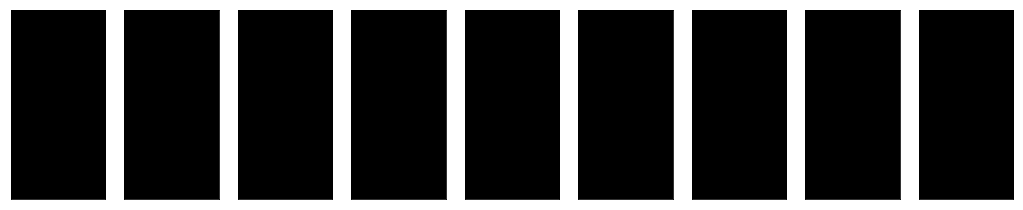

9.10905e-05


In [66]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot(x_test, decoded_imgs)
plot_encoding(encoded_imgs)

print(encoded_imgs.mean())

### Variational Autoencoder

In [1]:
from keras.layers import Lambda, Input, Dense
from keras import backend as K
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    retval= z_mean + K.exp(0.5 * z_log_var) * epsilon
    print(type(retval))
    print(retval.shape)
    return retval

# network parameters
original_dim=784
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss =  xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam',loss='')
vae.summary()

Using TensorFlow backend.


NameError: name 'original_dim' is not defined

In [101]:
# train
vae.fit(x_train,
                epochs=1,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test,None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 22s - loss: 213.3188 - val_loss: 180.8699

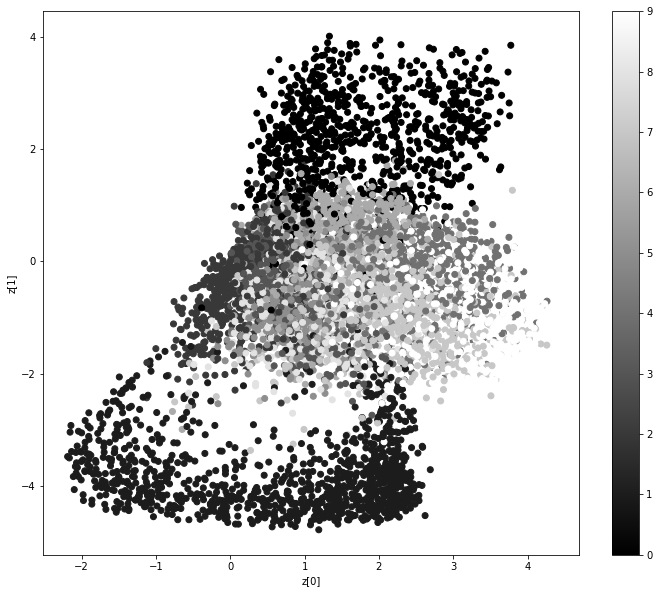

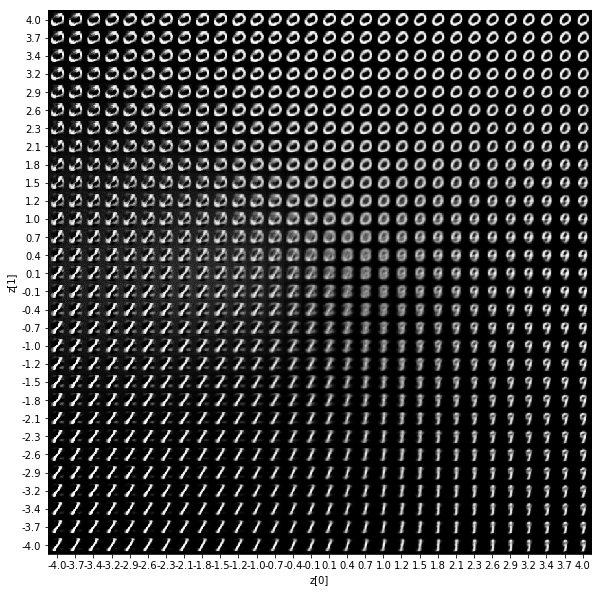

In [118]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    import os
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

models = (encoder,decoder)
data=(x_test,y_test)
batch_size = 128
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")